This code will load the model information, generate the model definition, and run the model estimation using FSL

In [23]:
import nipype.algorithms.modelgen as model   # model generation
import nipype.interfaces.fsl as fsl          # fsl
from nipype.interfaces.base import Bunch
import os,json,glob
import numpy
import nibabel
import nilearn.plotting

from make_event_files_from_json import MakeEventFilesFromJSON
%matplotlib inline
import matplotlib.pyplot as plt


try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'

print 'Using data from',datadir


Using data from /Users/poldrack/data_unsynced/myconnectome/sub00001


Load the scan and model info, and generate the event files for FSL from the information in model.json

In [10]:
subject='ses014'  
# note - we have to use the anatomy from a different session'
subdir=os.path.join(datadir,subject)
tasknum=2 # n-back

scaninfo=json.load(open(os.path.join(subdir,
        'functional/sub00001_ses014_task002_run001_bold.json')))
tr=scaninfo['RepetitionTime']

modelfile=os.path.join(subdir,'model.json')
modelinfo=json.load(open(modelfile))
taskinfo=modelinfo['task%03d'%tasknum]['model001']
evs=taskinfo['Variables']
contrasts=taskinfo['Contrasts']

# get the response onsets
response_onsets=[]

for v in evs.iterkeys():

    if evs[v]['VariableName'].find('_target_ons')>-1:
        for ons in evs[v]['onsets']:
            response_onsets.append(ons[0])



Specify the model.  For the sake of speed we will use a simplified model that treats the study as a blocked design rather than modeling each item separately, but we also model instructions and motor responses; this, it is a hybrid block/event-related design

In [11]:
modeldir=os.path.join(subdir,'model/task%03d/model001/featmodel'%tasknum)
# no way to specify the output directory, so we just chdir into the 
# desired output directory
if not os.path.exists(modeldir):
    os.mkdir(modeldir)
os.chdir(modeldir)

instruction_onsets=list(numpy.array([68,176,372,2,154,416,24,220,350,112,198,328,46,264,394,90,242,306])-2.0)

info = [Bunch(conditions=['faces-1back','faces-2back','scenes-1back','scenes-2back','chars-1back','chars-2back','instructions','responses'],
              onsets=[[68,176,372],[2,154,416],[24,220,350],[112,198,328],[46,264,394],[90,242,306],instruction_onsets,response_onsets],
              durations=[[20],[20],[20],[20],[20],[20],[2],[1]])
       ]

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = [os.path.join(subdir,'functional/sub00001_ses014_task002_run001_bold_mcf_unwarped_smoothed_hpf_rescaled.nii.gz')]
s.inputs.time_repetition = 6
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
s.run()




Generate the fsf and ev files using Level1Design

In [12]:
contrasts=[['faces>Baseline','T', ['faces-1back','faces-2back'],[0.5,0.5]],
           ['scenes>Baseline','T', ['scenes-1back','scenes-2back'],[0.5,0.5]],
           ['chars>Baseline','T', ['chars-1back','chars-2back'],[0.5,0.5]],
           ['2back>1back','T', 
            ['faces-1back','faces-2back','scenes-1back','scenes-2back','chars-1back','chars-2back'],[-1,1,-1,1,-1,1,-1,1]],
          ['response>Baseline','T',['responses'],[1]],
          ['instructions>Baseline','T',['instructions'],[1]]]
           
level1design = fsl.model.Level1Design()
level1design.inputs.interscan_interval = tr
level1design.inputs.bases = {'dgamma':{'derivs': True}}
level1design.inputs.session_info = s._sessinfo
level1design.inputs.model_serial_correlations=True
level1design.inputs.contrasts=contrasts
level1info=level1design.run() 

fsf_file=os.path.join(modeldir,'run0.fsf')
event_files=glob.glob(os.path.join(modeldir,'ev*txt'))


Generate the full set of model files using FEATModel

In [13]:
modelgen=fsl.model.FEATModel()
modelgen.inputs.fsf_file=fsf_file
modelgen.inputs.ev_files=event_files
modelgen.run()

Visualize the design matrix

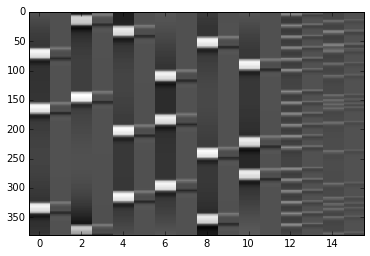

In [14]:
desmtx=numpy.loadtxt(fsf_file.replace(".fsf",".mat"),skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

Show the correlation matrix for design

<matplotlib.colorbar.Colorbar instance at 0x108b53b90>

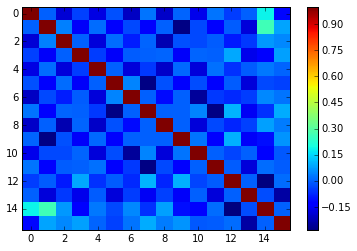

In [15]:
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest')
plt.colorbar()

Estimate the model using FILMGLS - this will take a few minutes.

In [28]:
if not os.path.exists(os.path.join(modeldir,'stats')):
    fgls = fsl.FILMGLS(smooth_autocorr=True,mask_size=5)
    fgls.inputs.in_file = os.path.join(subdir,
                                       'functional/sub00001_ses014_task002_run001_bold_mcf_unwarped_smoothed_hpf_rescaled.nii.gz')
    fgls.inputs.design_file = os.path.join(modeldir,'run0.mat')
    fgls.inputs.threshold = 10
    fgls.inputs.results_dir = os.path.join(modeldir,'stats')
    fgls.inputs.tcon_file=os.path.join(modeldir,'run0.con')
    res = fgls.run() 
else:
    print 'using existing stats dir'

using existing stats dir


In [29]:
# skip this for now, just do uncorrected visualization
dof=int(open(os.path.join(modeldir,'stats/dof')).readline().strip())
est = fsl.SmoothEstimate()
est.inputs.dof=dof
est.inputs.residual_fit_file = os.path.join(modeldir,'stats/res4d.nii.gz')
est.inputs.mask_file = os.path.join(subdir,'functional/sub00001_ses014_task002_run001_bold_mcf_brain_mask.nii.gz')
#smoothness=est.run()


/Users/poldrack/anaconda/lib/python2.7/site-packages/nipype/interfaces/base.py:397: UserWarning: Input residual_fit_file requires inputs: dof
  warn(msg)


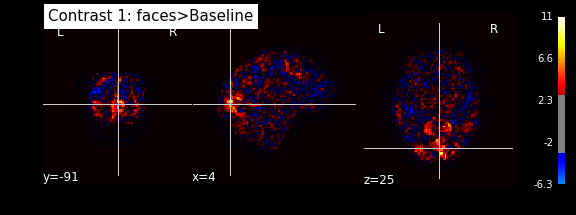

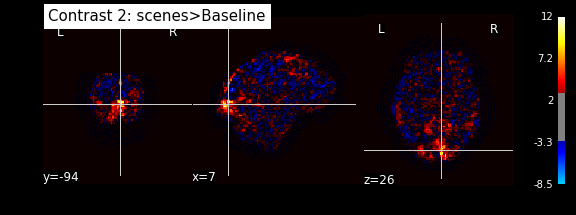

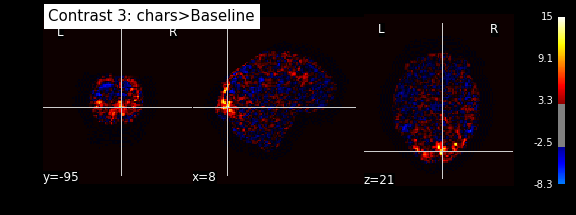

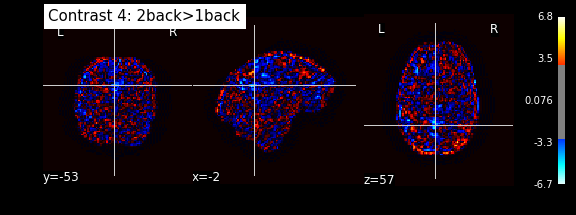

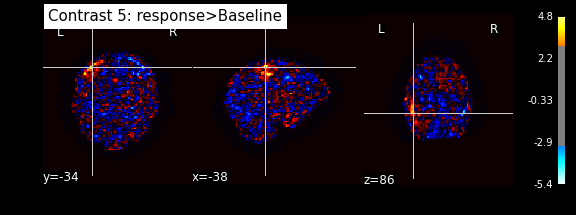

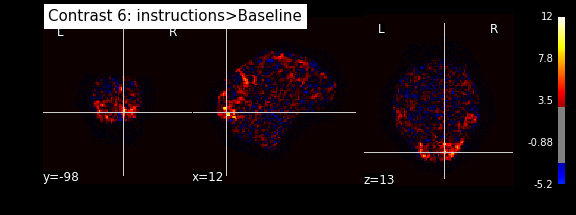

In [32]:
zstats=glob.glob(os.path.join(modeldir,'stats/zstat*.nii.gz'))
zstats.sort()
meanimg=nibabel.load(os.path.join(subdir,
                        'functional/sub00001_ses014_task002_run001_bold_mcf_brain_unwarped_mean.nii.gz'))

for zstat in zstats:
    connum=int(os.path.basename(zstat).split('.')[0].replace('zstat',''))
    zstatimg=nibabel.load(zstat)
    fmap_display=nilearn.plotting.plot_stat_map(zstatimg,meanimg,threshold=3,symmetric_cbar=False,
                title='Contrast %d: %s'%(connum,contrasts[connum-1][0]))
        